# The DIP methods used in this code are:
    1.Grayscale Conversion (rgb_to_grayscale): Converts the image to grayscale by removing color information.
    2.Gaussian Blur (gaussian_blur): Smoothens the image to reduce noise by averaging pixel values with a Gaussian kernel.
    3.Adaptive Thresholding (adaptive_threshold): Converts the image to binary (black and white) by setting pixel values based on the local mean intensity.
    4.Sobel Edge Detection (sobel/canny_edge_detection): Detects edges by computing the gradient magnitude of pixel intensities.
    5.Dilation (dilate): Expands bright regions to enhance edges or boundaries.
    6.Erosion (erode): Shrinks bright regions, helping to remove small white noise points.

# Model training and testing using inbuilt functions and libraries

Found 675 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Found 147 images belonging to 24 classes.
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.0699 - loss: 3.4899 - val_accuracy: 0.3194 - val_loss: 2.6583
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.2846 - loss: 2.5915 - val_accuracy: 0.4236 - val_loss: 2.1476
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.3766 - loss: 2.1762 - val_accuracy: 0.5278 - val_loss: 1.8356
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.4647 - loss: 1.8101 - val_accuracy: 0.5972 - val_loss: 1.5280
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.5243 - loss: 1.5889 - val_accuracy: 0.6319 - val_loss: 1.3458
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.5979 - loss: 1.3635 - val_accuracy: 0.5764 - val_loss: 1.2905
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.5907 - loss: 1.2981 - val_accuracy: 0.64

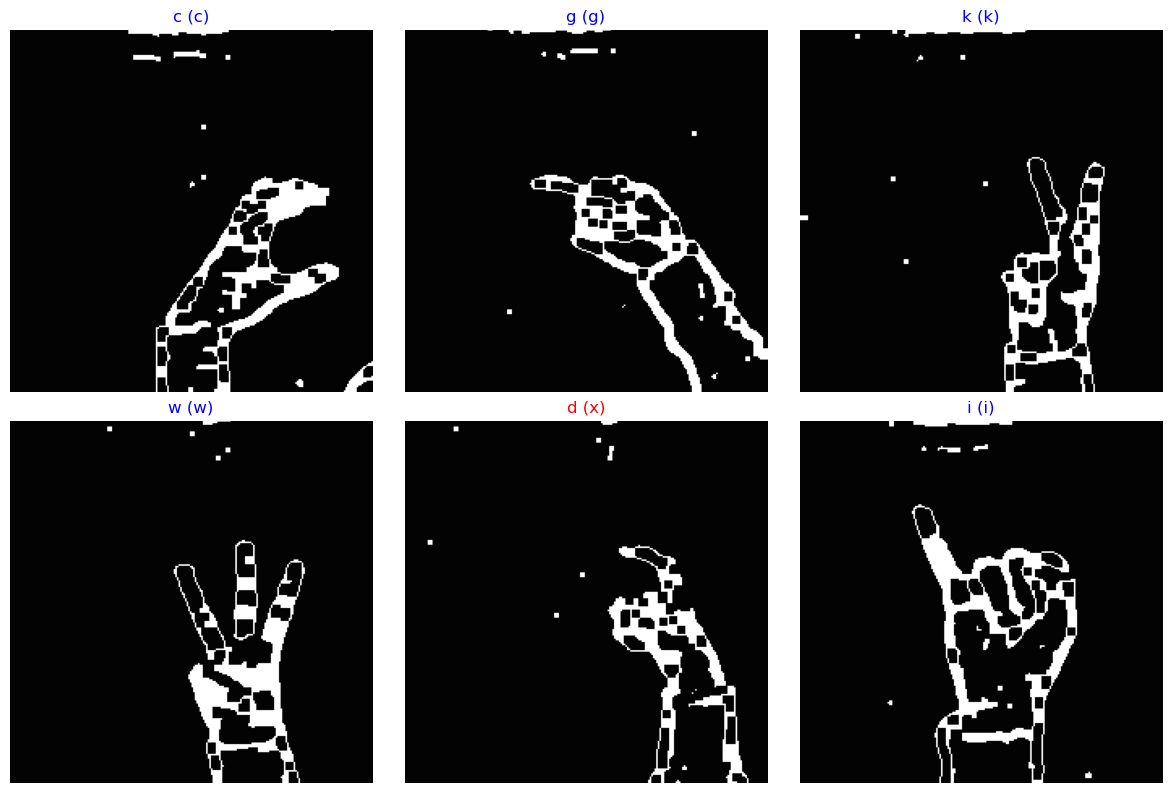

In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- DIP Preprocessing Function ---
def preprocess_image(image):
    # Resize image to MobileNetV2 input dimensions (224x224)
    image = cv2.resize(image, (224, 224))

    # Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Ensure blurred image is in uint8 format
    blurred = blurred.astype(np.uint8)

    # Apply Adaptive Thresholding
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # Perform Edge Detection
    edges = cv2.Canny(binary, threshold1=50, threshold2=150)

    # Morphological operations
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.dilate(edges, kernel, iterations=1)
    morphed = cv2.erode(morphed, kernel, iterations=1)

    # Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(morphed)

    # Resize and expand dimensions for MobileNetV2 input
    equalized = cv2.resize(equalized, (224, 224))
    equalized = np.expand_dims(equalized, axis=-1)  # Add channel dimension for grayscale
    equalized = np.repeat(equalized, 3, axis=-1)    # Convert to 3 channels for MobileNetV2

    return equalized

def preprocess_dataset(image):
    # Apply preprocessing to each image in the dataset
    image = tf.numpy_function(preprocess_image, [image], tf.float32)
    image.set_shape((224, 224, 3))  # Ensure shape is correct for MobileNetV2
    return image

# --- Data Loading and Preprocessing ---
# --- Data Loading and Preprocessing ---
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'

# Remove `rescale=1./255` since we're already normalizing in preprocess_image
datagen = ImageDataGenerator(preprocessing_function=preprocess_dataset)

train_data = datagen.flow_from_directory(train_dir, target_size=(224, 224), color_mode='rgb', batch_size=32, class_mode='categorical')
val_data = datagen.flow_from_directory(val_dir, target_size=(224, 224), color_mode='rgb', batch_size=32, class_mode='categorical')
test_data = datagen.flow_from_directory(test_dir, target_size=(224, 224), color_mode='rgb', batch_size=32, class_mode='categorical')
# --- MobileNetV2 Model Setup ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of MobileNetV2
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_data.num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# --- Model Compilation ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Model Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('asl_model_mobilenetv2_best.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# --- Model Training ---
history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stopping, checkpoint])

# Save the final model after training
model.save('finalv1.keras')  # HDF5 format

print("Model saved as 'asl_model_mobilenetv2_final.h5' and TensorFlow SavedModel format")

# --- Model Evaluation ---
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

# --- Prediction and Visualization ---
def visualize_predictions(model, test_data, class_names, num_images=6):
    images, labels = next(test_data)  # Get a batch of images and labels
    predictions = model.predict(images)  # Predict on this batch

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        actual_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis('off')
        
        # Set label color: Blue if correct, Red if incorrect
        color = "blue" if actual_label == predicted_label else "red"
        plt.title(f"{predicted_label} ({actual_label})", color=color)
    plt.tight_layout()
    plt.show()

# Class names from the training data
class_names = list(train_data.class_indices.keys())

# Visualize sample predictions
visualize_predictions(model, test_data, class_names)


Found 672 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Found 144 images belonging to 24 classes.


9406464/9406464 [==============================] - 3s 0us/step

Epoch 1/50


21/21 [==============================] - 1660s 80s/step - loss: 3.1773 - accuracy: 0.0848 - val_loss: 2.4823 - val_accuracy: 0.3056
Epoch 2/50
21/21 [==============================] - 1604s 77s/step - loss: 2.3446 - accuracy: 0.2902 - val_loss: 1.9825 - val_accuracy: 0.5208
Epoch 3/50
21/21 [==============================] - 1527s 73s/step - loss: 1.9205 - accuracy: 0.4226 - val_loss: 1.6487 - val_accuracy: 0.5833
Epoch 4/50
21/21 [==============================] - 1389s 66s/step - loss: 1.6154 - accuracy: 0.4955 - val_loss: 1.4275 - val_accuracy: 0.5833
Epoch 5/50
21/21 [==============================] - 806s 39s/step - loss: 1.3978 - accuracy: 0.5625 - val_loss: 1.2428 - val_accuracy: 0.6736
Epoch 6/50
21/21 [==============================] - 1239s 60s/step - loss: 1.1665 - accurac

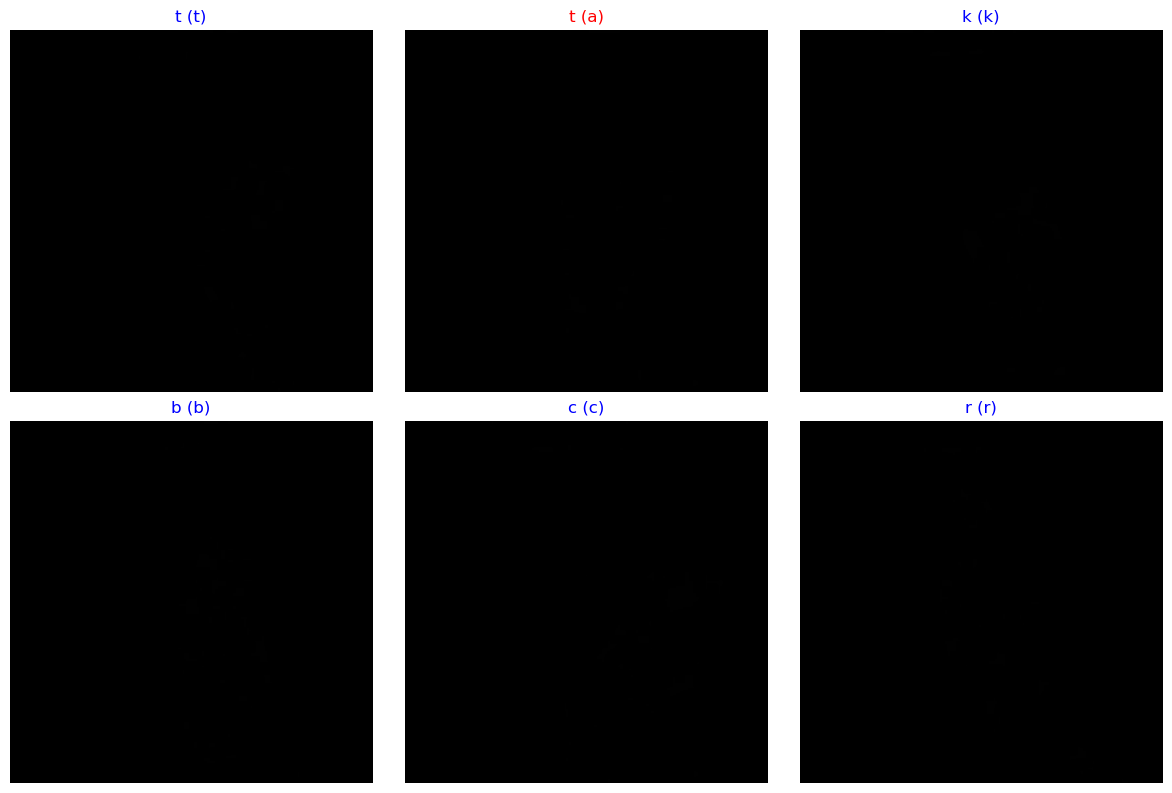

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt

# --- Manually Implemented DIP Preprocessing Functions ---

def rgb_to_grayscale(image):
    # Convert RGB to Grayscale
    return (0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]).astype(np.uint8)

def gaussian_blur(image, kernel_size=5, sigma=1):
    # Create a Gaussian kernel
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    kernel /= np.sum(kernel)

    # Apply the kernel to the image
    padded_image = np.pad(image, kernel_size // 2, mode='reflect')
    blurred_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            blurred_image[i, j] = np.sum(region * kernel)

    return blurred_image.astype(np.uint8)

def adaptive_threshold(image, window_size=11, C=2):
    # Adaptive thresholding to binary image
    half_window = window_size // 2
    padded_image = np.pad(image, half_window, mode='reflect')
    thresholded_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+window_size, j:j+window_size]
            local_mean = np.mean(region)
            thresholded_image[i, j] = 255 if image[i, j] > local_mean - C else 0

    return thresholded_image

def sobel_edge_detection(image):
    # Sobel edge detection
    Kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    
    padded_image = np.pad(image, 1, mode='reflect')
    
    for i in range(1, image.shape[0] + 1):
        for j in range(1, image.shape[1] + 1):
            region = padded_image[i-1:i+2, j-1:j+2]
            Ix[i-1, j-1] = np.sum(Kx * region)
            Iy[i-1, j-1] = np.sum(Ky * region)
    
    gradient_magnitude = np.sqrt(Ix**2 + Iy**2)
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255
    return gradient_magnitude.astype(np.uint8)

def dilate(image, kernel_size=5):
    # Dilation to enhance bright regions
    padded_image = np.pad(image, kernel_size // 2, mode='constant', constant_values=0)
    dilated_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            dilated_image[i, j] = np.max(region)

    return dilated_image

def erode(image, kernel_size=5):
    # Erosion to shrink bright regions
    padded_image = np.pad(image, kernel_size // 2, mode='constant', constant_values=255)
    eroded_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            eroded_image[i, j] = np.min(region)

    return eroded_image

def preprocess_image(image):
    # Resize to MobileNetV2 input dimensions (224x224)
    image = cv2.resize(image, (224, 224))

    # Convert to Grayscale
    gray = rgb_to_grayscale(image)

    # Apply Gaussian Blur
    blurred = gaussian_blur(gray, kernel_size=5)

    # Apply Adaptive Thresholding
    binary = adaptive_threshold(blurred, window_size=11, C=2)

    # Perform Edge Detection
    edges = sobel_edge_detection(binary)

    # Morphological operations
    morphed = dilate(edges, kernel_size=5)
    morphed = erode(morphed, kernel_size=5)

    # Resize and normalize for MobileNetV2 input
    processed_image = cv2.resize(morphed, (224, 224))
    processed_image = np.expand_dims(processed_image, axis=-1)  # Add channel dimension for grayscale
    processed_image = np.repeat(processed_image, 3, axis=-1)    # Convert to 3 channels for MobileNetV2

    return processed_image.astype(np.float32) / 255.0  # Normalize to [0, 1]

# Integrate the preprocessing function in the data pipeline
def preprocess_dataset(image):
    # Apply preprocessing to each image in the dataset
    image = tf.numpy_function(preprocess_image, [image], tf.float32)
    image.set_shape((224, 224, 3))  # Ensure shape is correct for MobileNetV2
    return image

# --- Data Loading and Preprocessing ---
train_dir = 'dataset_split_colour_2/train'
val_dir = 'dataset_split_colour_2/val'
test_dir = 'dataset_split_colour_2/test'

datagen = ImageDataGenerator(preprocessing_function=preprocess_dataset)

train_data = datagen.flow_from_directory(train_dir, target_size=(224, 224), color_mode='rgb', batch_size=32, class_mode='categorical')
val_data = datagen.flow_from_directory(val_dir, target_size=(224, 224), color_mode='rgb', batch_size=32, class_mode='categorical')
test_data = datagen.flow_from_directory(test_dir, target_size=(224, 224), color_mode='rgb', batch_size=32, class_mode='categorical')

# --- MobileNetV2 Model Setup ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of MobileNetV2
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_data.num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# --- Model Compilation ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Model Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('asl_model_mobilenetv2_best.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# --- Model Training ---
history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stopping, checkpoint])

# Save the final model
model.save('finalv1.keras')

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

# --- Prediction and Visualization ---
def visualize_predictions(model, test_data, class_names, num_images=6):
    images, labels = next(test_data)  # Get a batch of images and labels
    predictions = model.predict(images)  # Predict on this batch

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        actual_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis('off')
        
        # Set label color: Blue if correct, Red if incorrect
        color = "blue" if actual_label == predicted_label else "red"
        plt.title(f"{predicted_label} ({actual_label})", color=color)
    plt.tight_layout()
    plt.show()

# Get class names and visualize sample predictions
class_names = list(train_data.class_indices.keys())
visualize_predictions(model, test_data, class_names)


# Showing what the actual preprocessed image looks like(using libraries) - this will be input for model

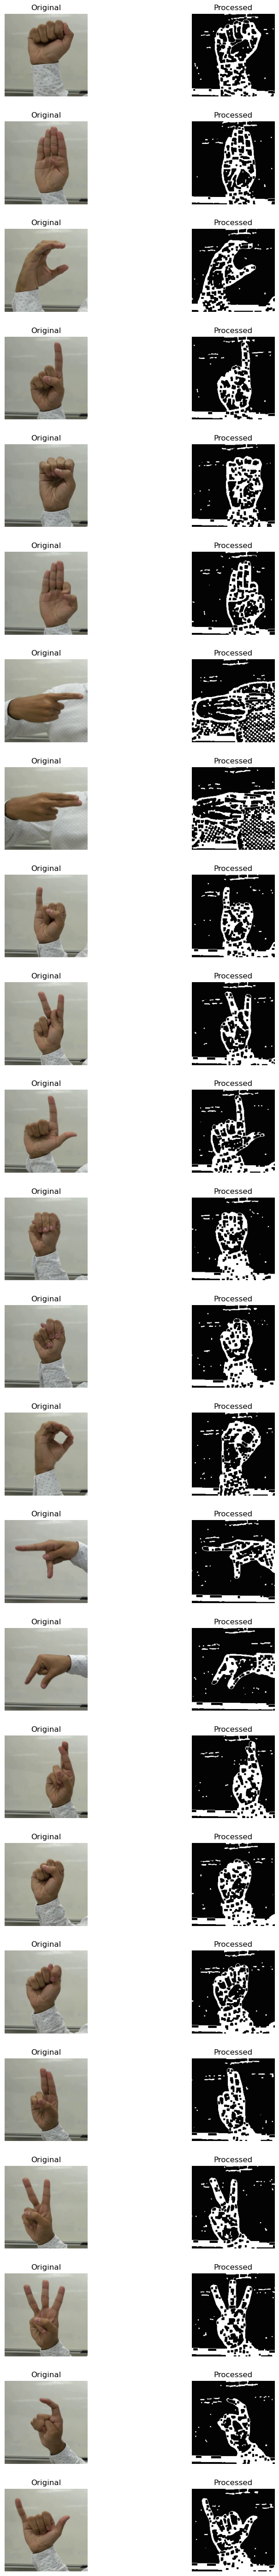

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the DIP preprocessing function
def preprocess_image(image):
    # Resize image to 224x224
    image = cv2.resize(image, (224, 224))

    # Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Adaptive Thresholding
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    
    # Perform Edge Detection
    edges = cv2.Canny(binary, threshold1=50, threshold2=150)
    
    # Morphological operations
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.dilate(edges, kernel, iterations=1)
    morphed = cv2.erode(morphed, kernel, iterations=1)
    
    # Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(morphed)
    
    # Convert to 3 channels for consistency with color images
    equalized = cv2.merge([equalized, equalized, equalized])
    
    return equalized

# Function to display processed images from multiple paths
def display_processed_images_from_paths(image_paths):
    images = []
    processed_images = []
    
    # Load and process images from the provided paths
    for image_path in image_paths:
        image = cv2.imread(image_path)
        
        if image is not None:
            processed_image = preprocess_image(image)
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Original image in RGB
            processed_images.append(processed_image)

    # Display each original and processed image pair in its own row
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3), gridspec_kw={'wspace': 0.1, 'hspace': 0.3})

    for i in range(num_images):
        # Display original image on the left
        axes[i, 0].imshow(images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original", fontsize=12)
        
        # Display processed image on the right
        axes[i, 1].imshow(processed_images[i])
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Processed", fontsize=12)

    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()

# List of image paths to process
image_paths = [
    'dataset/train/a/a_1-19.jpg',
    'dataset/train/b/b_1-19.jpg',
    'dataset/train/c/c_1-19.jpg',
    'dataset/train/d/d_1-19.jpg',
    'dataset/train/e/e_1-19.jpg',
    'dataset/train/f/f_1-19.jpg',
    'dataset/train/g/g_1-19.jpg',
    'dataset/train/h/h_1-19.jpg',
    'dataset/train/i/i_1-19.jpg',
    'dataset/train/k/k_1-19.jpg',
    'dataset/train/l/l_1-19.jpg',
    'dataset/train/m/m_1-19.jpg',
    'dataset/train/n/n_1-19.jpg',
    'dataset/train/o/o_1-19.jpg',
    'dataset/train/p/p_1-19.jpg',
    'dataset/train/q/q_1-19.jpg',
    'dataset/train/r/r_1-19.jpg',
    'dataset/train/s/s_1-19.jpg',
    'dataset/train/t/t_1-19.jpg',
    'dataset/train/u/u_1-19.jpg',
    'dataset/train/v/v_1-19.jpg',
    'dataset/train/w/w_1-19.jpg',
    'dataset/train/x/x_1-19.jpg',
    'dataset/train/y/y_1-19.jpg',
]

# Call the function to display processed images
display_processed_images_from_paths(image_paths)

# Showing what the actual preprocessed image looks like(without using libraries) - this will be input for model

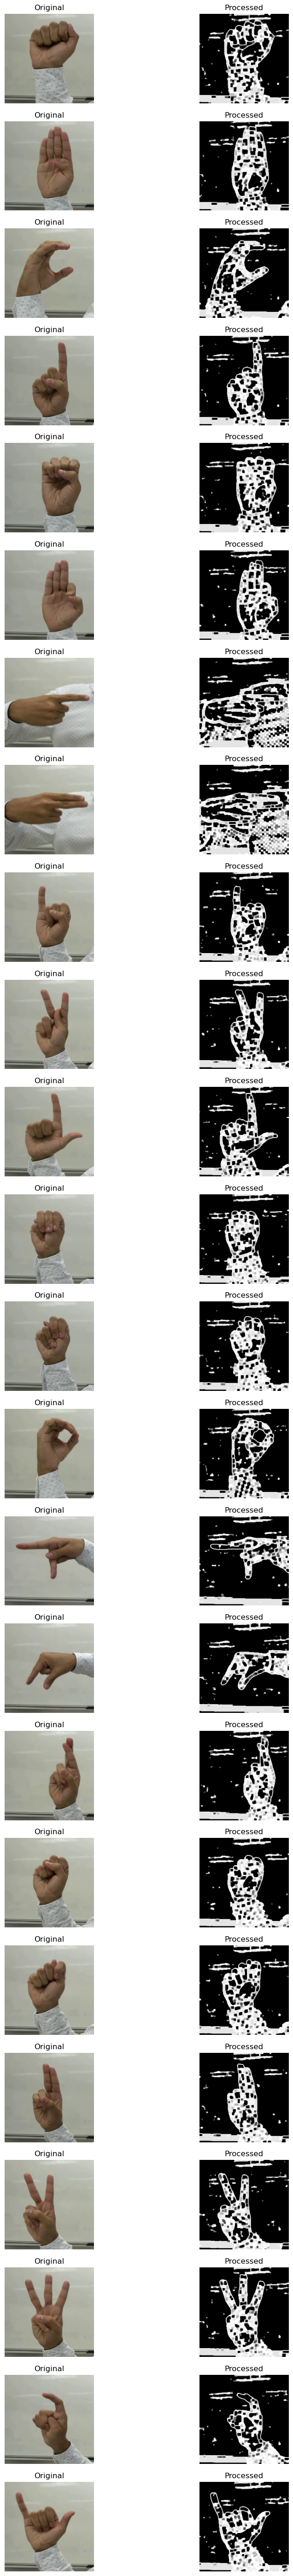

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Manually Implemented DIP Preprocessing Function ---
def rgb_to_grayscale(image):
    return (0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]).astype(np.uint8)

def gaussian_blur(image, kernel_size=5, sigma=1):
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    kernel /= np.sum(kernel)

    padded_image = np.pad(image, kernel_size // 2, mode='reflect')
    blurred_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            blurred_image[i, j] = np.sum(region * kernel)

    return blurred_image

def adaptive_threshold(image, window_size=11, C=2):
    half_window = window_size // 2
    padded_image = np.pad(image, half_window, mode='reflect')
    thresholded_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+window_size, j:j+window_size]
            local_mean = np.mean(region)
            thresholded_image[i, j] = 255 if image[i, j] > local_mean - C else 0

    return thresholded_image

def sobel_edge_detection(image):
    Kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    
    padded_image = np.pad(image, 1, mode='reflect')
    
    for i in range(1, image.shape[0] + 1):
        for j in range(1, image.shape[1] + 1):
            region = padded_image[i-1:i+2, j-1:j+2]
            Ix[i-1, j-1] = np.sum(Kx * region)
            Iy[i-1, j-1] = np.sum(Ky * region)
    
    gradient_magnitude = np.sqrt(Ix**2 + Iy**2)
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255
    return gradient_magnitude.astype(np.uint8)

def dilate(image, kernel_size=5):
    padded_image = np.pad(image, kernel_size // 2, mode='constant', constant_values=0)
    dilated_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            dilated_image[i, j] = np.max(region)

    return dilated_image

def erode(image, kernel_size=5):
    padded_image = np.pad(image, kernel_size // 2, mode='constant', constant_values=255)
    eroded_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            eroded_image[i, j] = np.min(region)

    return eroded_image

def preprocess_image(image):
    # Convert to Grayscale
    gray = rgb_to_grayscale(image)

    # Apply Gaussian Blur
    blurred = gaussian_blur(gray, kernel_size=5)

    # Apply Adaptive Thresholding
    binary = adaptive_threshold(blurred, window_size=11, C=2)

    # Perform Edge Detection
    edges = sobel_edge_detection(binary)

    # Morphological operations
    morphed = dilate(edges, kernel_size=5)
    morphed = erode(morphed, kernel_size=5)

    # Resize to ensure consistency
    equalized = cv2.resize(morphed, (224, 224))
    equalized = np.expand_dims(equalized, axis=-1)  # Add channel dimension for grayscale
    equalized = np.repeat(equalized, 3, axis=-1)    # Convert to 3 channels for MobileNetV2

    return equalized

# Function to display processed images from multiple paths
def display_processed_images(image_paths):
    images = []
    processed_images = []

    # Load and process images from the provided paths
    for image_path in image_paths:
        image = cv2.imread(image_path)
        
        if image is not None:
            image = cv2.resize(image, (224, 224))
            processed_image = preprocess_image(image)

            # Convert BGR to RGB for displaying
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            processed_images.append(processed_image)

    # Display original and processed images in pairs
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i in range(num_images):
        # Display original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original", fontsize=12)
        
        # Display processed image
        axes[i, 1].imshow(processed_images[i].astype("uint8"))
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Processed", fontsize=12)

    plt.show()

# List of image paths to process
image_paths = [
    'dataset/train/a/a_1-19.jpg',
    'dataset/train/b/b_1-19.jpg',
    'dataset/train/c/c_1-19.jpg',
    'dataset/train/d/d_1-19.jpg',
    'dataset/train/e/e_1-19.jpg',
    'dataset/train/f/f_1-19.jpg',
    'dataset/train/g/g_1-19.jpg',
    'dataset/train/h/h_1-19.jpg',
    'dataset/train/i/i_1-19.jpg',
    'dataset/train/k/k_1-19.jpg',
    'dataset/train/l/l_1-19.jpg',
    'dataset/train/m/m_1-19.jpg',
    'dataset/train/n/n_1-19.jpg',
    'dataset/train/o/o_1-19.jpg',
    'dataset/train/p/p_1-19.jpg',
    'dataset/train/q/q_1-19.jpg',
    'dataset/train/r/r_1-19.jpg',
    'dataset/train/s/s_1-19.jpg',
    'dataset/train/t/t_1-19.jpg',
    'dataset/train/u/u_1-19.jpg',
    'dataset/train/v/v_1-19.jpg',
    'dataset/train/w/w_1-19.jpg',
    'dataset/train/x/x_1-19.jpg',
    'dataset/train/y/y_1-19.jpg',
]

# Call the function to display processed images
display_processed_images(image_paths)

## without inbuilt libraries

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# --- DIP Preprocessing Functions ---
def rgb_to_grayscale(image):
    return (0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]).astype(np.uint8)

def gaussian_blur(image, kernel_size=5, sigma=1):
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    kernel /= np.sum(kernel)

    padded_image = np.pad(image, kernel_size // 2, mode='reflect')
    blurred_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            blurred_image[i, j] = np.sum(region * kernel)

    return blurred_image.astype(np.uint8)

def adaptive_threshold(image, window_size=11, C=2):
    half_window = window_size // 2
    padded_image = np.pad(image, half_window, mode='reflect')
    thresholded_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+window_size, j:j+window_size]
            local_mean = np.mean(region)
            thresholded_image[i, j] = 255 if image[i, j] > local_mean - C else 0

    return thresholded_image

def sobel_edge_detection(image):
    Kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    
    padded_image = np.pad(image, 1, mode='reflect')
    
    for i in range(1, image.shape[0] + 1):
        for j in range(1, image.shape[1] + 1):
            region = padded_image[i-1:i+2, j-1:j+2]
            Ix[i-1, j-1] = np.sum(Kx * region)
            Iy[i-1, j-1] = np.sum(Ky * region)
    
    gradient_magnitude = np.sqrt(Ix**2 + Iy**2)
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255
    return gradient_magnitude.astype(np.uint8)

def dilate(image, kernel_size=5):
    padded_image = np.pad(image, kernel_size // 2, mode='constant', constant_values=0)
    dilated_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            dilated_image[i, j] = np.max(region)

    return dilated_image

def erode(image, kernel_size=5):
    padded_image = np.pad(image, kernel_size // 2, mode='constant', constant_values=255)
    eroded_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            eroded_image[i, j] = np.min(region)

    return eroded_image

def preprocess_image(image):
    # Convert to Grayscale
    gray = rgb_to_grayscale(image)

    # Apply Gaussian Blur
    blurred = gaussian_blur(gray, kernel_size=5)

    # Apply Adaptive Thresholding
    binary = adaptive_threshold(blurred, window_size=11, C=2)

    # Perform Edge Detection
    edges = sobel_edge_detection(binary)

    # Morphological operations
    morphed = dilate(edges, kernel_size=5)
    morphed = erode(morphed, kernel_size=5)

    # Resize to ensure consistency
    processed_image = cv2.resize(morphed, (224, 224))
    processed_image = np.expand_dims(processed_image, axis=-1)  # Add channel dimension for grayscale
    processed_image = np.repeat(processed_image, 3, axis=-1)    # Convert to 3 channels

    return processed_image

# --- Dataset Processing ---
def create_processed_dataset(input_dir, output_dir):
    # Iterate through train/val/test directories
    for split in ['train', 'val', 'test']:
        split_input_dir = os.path.join(input_dir, split)
        split_output_dir = os.path.join(output_dir, split)

        # Create the split directory in the output dataset
        os.makedirs(split_output_dir, exist_ok=True)

        # Iterate through class folders
        for class_name in os.listdir(split_input_dir):
            class_input_dir = os.path.join(split_input_dir, class_name)
            class_output_dir = os.path.join(split_output_dir, class_name)

            # Create the class directory in the output dataset
            os.makedirs(class_output_dir, exist_ok=True)

            # Process each image in the class folder
            for image_name in tqdm(os.listdir(class_input_dir), desc=f"Processing {class_name} in {split}"):
                image_path = os.path.join(class_input_dir, image_name)
                output_path = os.path.join(class_output_dir, image_name)

                # Read the image
                image = cv2.imread(image_path)
                if image is None:
                    continue

                # Preprocess the image
                processed_image = preprocess_image(image)

                # Save the processed image
                cv2.imwrite(output_path, (processed_image * 255).astype(np.uint8))

# Input and output directories
input_dir = 'dataset'  # Original dataset directory
output_dir = 'noinbuilt_dataset'      # Processed dataset directory

# Create the processed dataset
create_processed_dataset(input_dir, output_dir)

print(f"Processed dataset created at {output_dir}")

Processing w in test: 100%|███████████████████████| 6/6 [00:11<00:00,  1.90s/it]

Processed dataset created at noinbuilt_dataset
